In [4]:
import pandas as pd
import numpy as np

In [6]:
df = pd.read_csv("../../Datasets/3_earthquake_1995-2023.csv")

In [3]:

df.head()

,title,magnitude,cdi,mmi,alert,tsunami,sig,net,nst,dmin,...,magType,depth,latitude,longitude,location,continent,country,day,month,year
0,"M 6.5 - 42 km W of Sola, Vanuatu",6.5,7,4,green,0,657,us,114,7.177000,...,mww,192.955,-13.88,167.16,"Sola, Vanuatu",Oceania,Vanuatu,16,8,2023
1,"M 6.5 - 43 km S of Intipucá, El Salvador",6.5,8,6,yellow,0,775,us,92,0.679000,...,mww,69.727,12.81,-88.13,"Intipucá, El Salvador",North America,El Salvador,19,7,2023
2,"M 6.6 - 25 km ESE of Loncopué, Argentina",6.6,7,5,green,0,899,us,70,1.634000,...,mww,171.371,-38.19,-70.37,"Loncopué, Argentina",South America,Argentina,17,7,2023
3,"M 7.2 - 98 km S of Sand Point, Alaska",7.2,6,6,green,1,860,us,173,0.907000,...,mww,32.571,54.38,-160.70,"Sand Point, Alaska",North America,United States,16,7,2023
4,M 7.3 - Alaska Peninsula,7.3,0,5,No alert,1,820,at,79,0.879451,...,Mi,21.000,54.49,-160.80,Alaska Peninsula,North America,United States,16,7,2023


In [4]:
df["alert"].unique()

array(['green', 'yellow', 'No alert', 'orange', 'red'], dtype=object)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974 entries, 0 to 973
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      974 non-null    object 
 1   magnitude  974 non-null    float64
 2   cdi        974 non-null    int64  
 3   mmi        974 non-null    int64  
 4   alert      974 non-null    object 
 5   tsunami    974 non-null    int64  
 6   sig        974 non-null    int64  
 7   net        974 non-null    object 
 8   nst        974 non-null    int64  
 9   dmin       974 non-null    float64
 10  gap        974 non-null    float64
 11  magType    974 non-null    object 
 12  depth      974 non-null    float64
 13  latitude   974 non-null    float64
 14  longitude  974 non-null    float64
 15  location   974 non-null    object 
 16  continent  974 non-null    object 
 17  country    974 non-null    object 
 18  day        974 non-null    int64  
 19  month      974 non-null    int64  
 20  year      

In [6]:
df.head(20)

,title,magnitude,cdi,mmi,alert,tsunami,sig,net,nst,dmin,...,magType,depth,latitude,longitude,location,continent,country,day,month,year
0,"M 6.5 - 42 km W of Sola, Vanuatu",6.5,7,4,green,0,657,us,114,7.177000,...,mww,192.955,-13.88,167.16,"Sola, Vanuatu",Oceania,Vanuatu,16,8,2023
1,"M 6.5 - 43 km S of Intipucá, El Salvador",6.5,8,6,yellow,0,775,us,92,0.679000,...,mww,69.727,12.81,-88.13,"Intipucá, El Salvador",North America,El Salvador,19,7,2023
2,"M 6.6 - 25 km ESE of Loncopué, Argentina",6.6,7,5,green,0,899,us,70,1.634000,...,mww,171.371,-38.19,-70.37,"Loncopué, Argentina",South America,Argentina,17,7,2023
3,"M 7.2 - 98 km S of Sand Point, Alaska",7.2,6,6,green,1,860,us,173,0.907000,...,mww,32.571,54.38,-160.70,"Sand Point, Alaska",North America,United States,16,7,2023
4,M 7.3 - Alaska Peninsula,7.3,0,5,No alert,1,820,at,79,0.879451,...,Mi,21.000,54.49,-160.80,Alaska Peninsula,North America,United States,16,7,2023
5,"M 6.6 - 277 km NNE of Codrington, Antigua and ...",6.6,5,4,green,1,802,us,95,2.454000,...,mww,10.000,20.02,-61.10,"Codrington, Antigua and Barbuda",North America,Antigua and Barbuda,10,7,2023
6,M 6.9 - Tonga,6.9,4,4,green,1,741,us,136,1.179000,...,mww,229.000,-17.85,-174.94,Tonga,Oceania,Tonga,2,7,2023
7,M 7.2 - south of the Fiji Islands,7.2,8,6,green,1,804,us,85,2.590000,...,mww,167.404,-22.98,-177.21,the Fiji Islands,Oceania,Fiji,15,6,2023
8,M 6.6 - Panama-Colombia border region,6.6,6,6,green,1,733,us,50,2.163000,...,mww,10.000,8.89,-77.12,Panama-Colombia border region,South America,Colombia,25,5,2023
9,M 7.1 - southeast of the Loyalty Islands,7.1,3,4,green,1,777,us,98,2.812000,...,mww,35.981,-23.06,170.46,the Loyalty Islands,Europe,France,20,5,2023


# Feature Engineering 

In [7]:
df_model = df.drop(columns=["title"],axis=0)

In [8]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
encode_list= ["net","magType","location","continent","country","alert"]

for i in encode_list :
    df_model[i]= le.fit_transform(df_model[i])

In [9]:
df_model

,magnitude,cdi,mmi,alert,tsunami,sig,net,nst,dmin,gap,magType,depth,latitude,longitude,location,continent,country,day,month,year
0,6.5,7,4,1,0,657,9,114,7.177000,25.0,8,192.955,-13.88,167.16,427,5,60,16,8,2023
1,6.5,8,6,4,0,775,9,92,0.679000,40.0,8,69.727,12.81,-88.13,156,4,18,19,7,2023
2,6.6,7,5,1,0,899,9,70,1.634000,28.0,8,171.371,-38.19,-70.37,233,6,4,17,7,2023
3,7.2,6,6,1,1,860,9,173,0.907000,36.0,8,32.571,54.38,-160.70,402,4,59,16,7,2023
4,7.3,0,5,0,1,820,1,79,0.879451,172.8,0,21.000,54.49,-160.80,17,4,59,16,7,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,7.1,0,9,0,0,776,9,0,0.000000,0.0,6,11.000,52.63,142.83,466,2,47,27,5,1995
970,7.7,0,4,0,0,912,9,0,0.000000,0.0,5,20.200,-23.01,169.90,478,3,20,16,5,1995
971,6.9,0,6,0,0,732,9,0,0.000000,0.0,5,11.200,-8.38,125.13,258,2,28,14,5,1995
972,6.6,0,9,0,0,670,9,0,0.000000,0.0,5,14.000,40.15,21.70,14,3,21,13,5,1995


## Feature selection for CDI

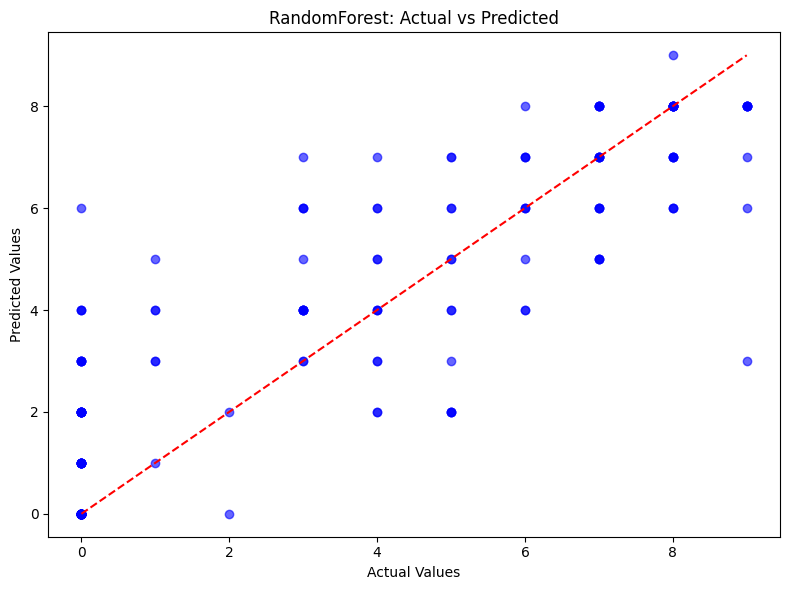

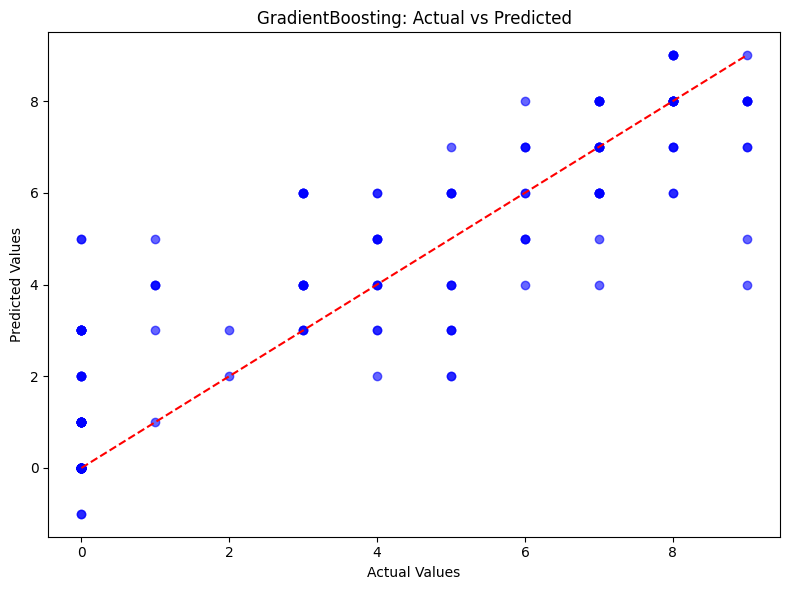

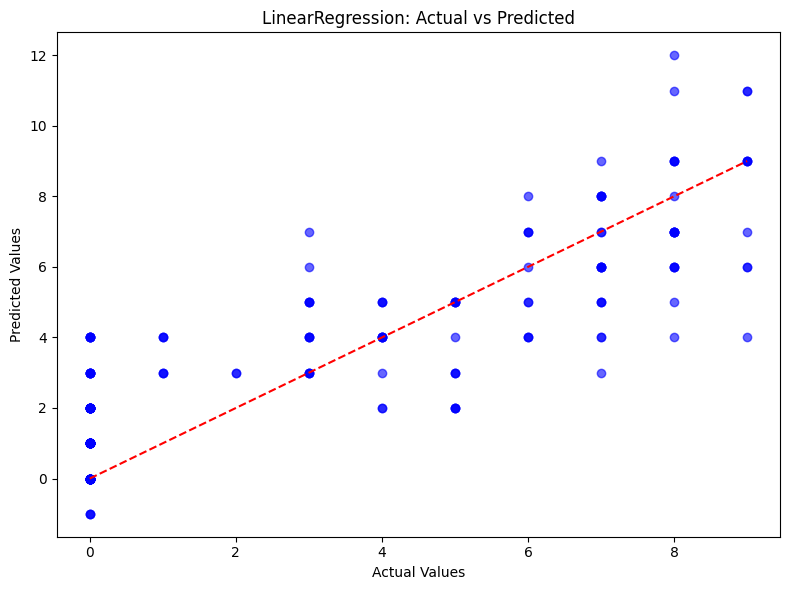

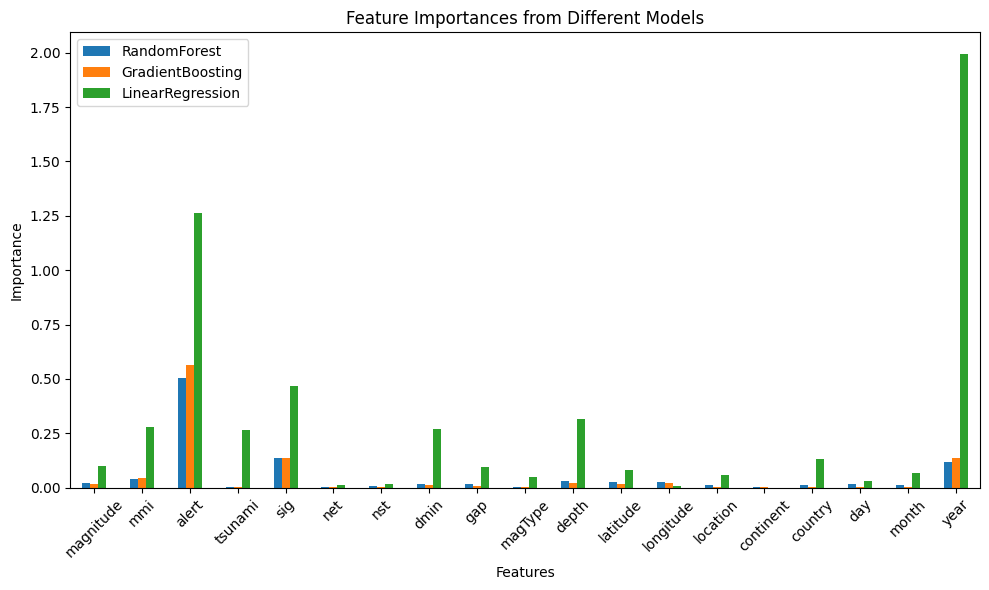

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Example data loading
# Replace with your own dataframe 'df'
# Assuming df is already loaded and contains a column 'cdi' as the target
X = df_model.drop('cdi', axis=1)  # 'cdi' is the target column
y = df_model['cdi']  # 'cdi' is the target variable

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "LinearRegression": LinearRegression()
}

# Fit models and get feature importances
feature_importances = {}
predictions = {}

for model_name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Get feature importance for tree-based models
    if model_name != "LinearRegression":
        feature_importances[model_name] = model.feature_importances_
    else:
        # For Linear Regression, use the absolute values of coefficients as importance
        feature_importances[model_name] = np.abs(model.coef_)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Round the predictions to nearest integers
    y_pred_rounded = np.round(y_pred).astype(int)
    predictions[model_name] = y_pred_rounded

    # Plot the actual vs predicted values for each model
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_rounded, color='blue', alpha=0.6)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.title(f'{model_name}: Actual vs Predicted')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.tight_layout()
    plt.show()

# Create a DataFrame to store feature importance from each model
importance_df = pd.DataFrame(feature_importances, index=X.columns)

# Plot the feature importances
importance_df.plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importances from Different Models')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
importance_GB = importance_df["RandomForest"].sort_values(ascending = False)[0:4]

In [12]:
importance_GB_li = list(importance_GB.index)

In [13]:
type(importance_GB_li)

list

In [14]:
importance_GB_li

['alert', 'sig', 'year', 'mmi']

### Model fitting

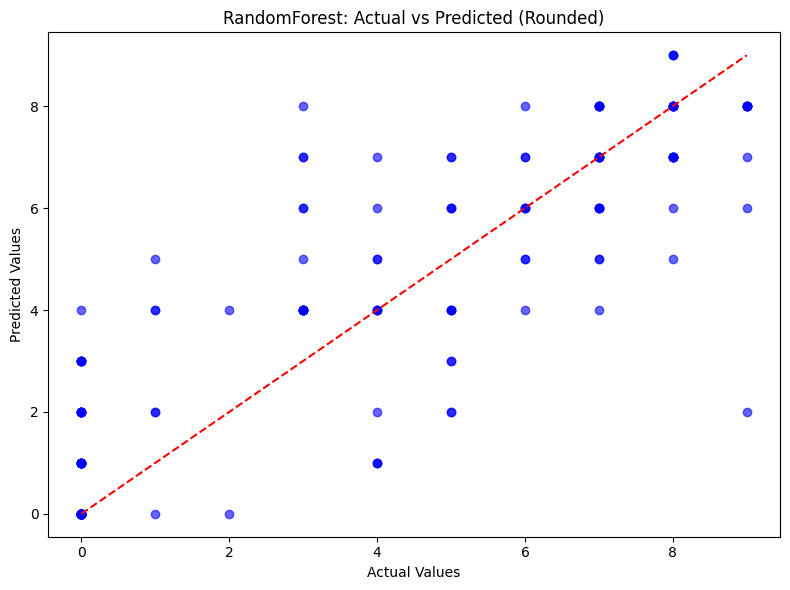

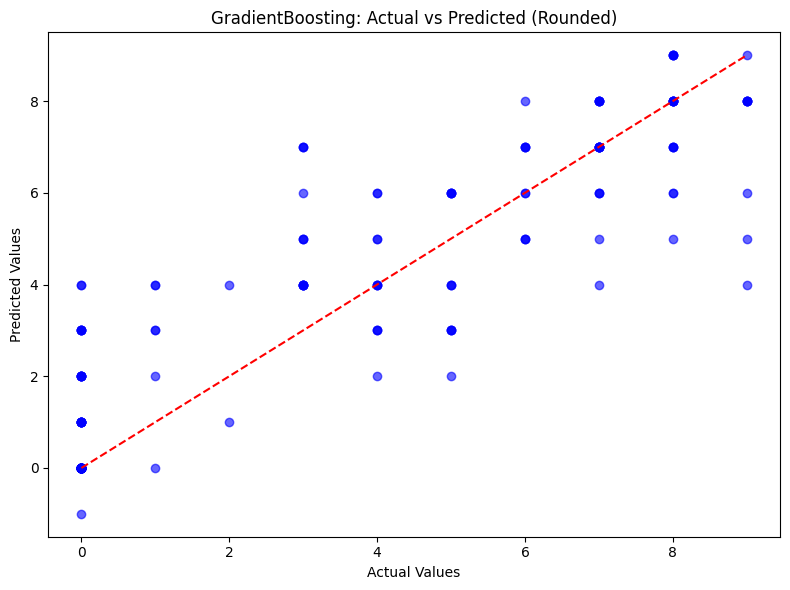

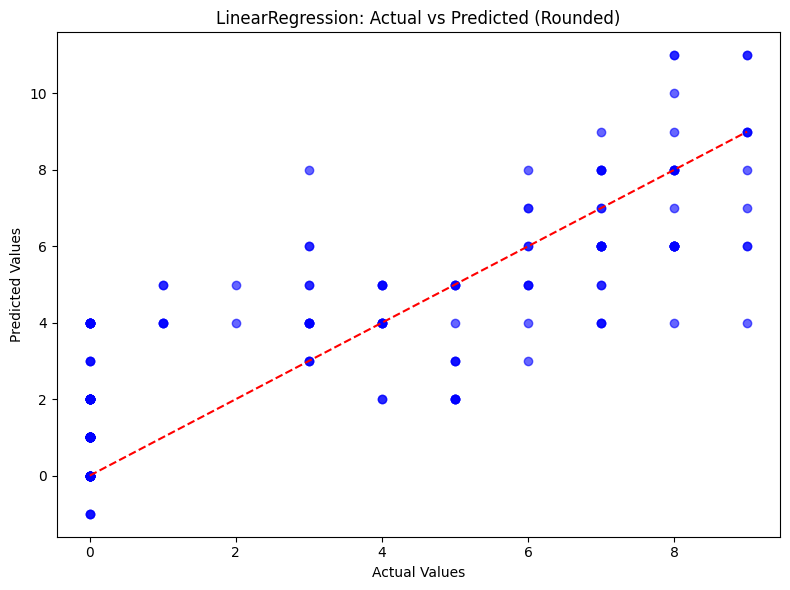

                  R² Score  Mean Squared Error
RandomForest      0.784389            2.374359
GradientBoosting  0.812330            2.066667
LinearRegression  0.663777            3.702564


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

# Example data loading
# Replace with your own dataframe 'df'
# Assuming df is already loaded and contains a column 'cdi' as the target
X = df_model[importance_GB_li]  # 'cdi' is the target column
y = df_model['cdi']  # 'cdi' is the target variable

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "LinearRegression": LinearRegression()
}

# To store results
results = {}

# Fit models and calculate R² score and MSE
for model_name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Round the predictions to the nearest integer
    y_pred_rounded = np.round(y_pred).astype(int)

    # Calculate R² score and Mean Squared Error
    r2 = r2_score(y_test, y_pred_rounded)
    mse = mean_squared_error(y_test, y_pred_rounded)
    
    # Store the results
    results[model_name] = {
        'R² Score': r2,
        'Mean Squared Error': mse
    }

    # Plot the actual vs predicted values for each model
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_rounded, color='blue', alpha=0.6)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.title(f'{model_name}: Actual vs Predicted (Rounded)')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.tight_layout()
    plt.show()

# Display the results
results_df = pd.DataFrame(results).T
print(results_df)


In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor

# Example data loading
# Replace with your own dataframe 'df'
X = df_model[importance_GB_li]  # 'cdi' is the target column
y = df_model['cdi'] # 'cdi' is the target variable

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR(kernel='rbf'),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
}

# To store results
results = {}

# Fit models and evaluate performance
for model_name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    
    # Round the predictions to the nearest integer
    y_pred_rounded = np.round(y_pred).astype(int)

    # Clip the predictions to ensure they are between 0 and 9
    y_pred_clipped = np.clip(y_pred_rounded, 0, 9)

    # Calculate R² score and Mean Squared Error
    r2 = r2_score(y_test, y_pred_clipped)
    mse = mean_squared_error(y_test, y_pred_clipped)

    # Store the results
    results[model_name] = {
        'R² Score': r2,
        'Mean Squared Error': mse
    }

# Display the results
results_df = pd.DataFrame(results).T
print(results_df)


                  R² Score  Mean Squared Error
ElasticNet        0.679610            3.528205
RandomForest      0.784389            2.374359
GradientBoosting  0.812796            2.061538
SVR               0.690787            3.405128
XGBoost           0.812330            2.066667


In [17]:
y_pred_rounded

array([ 6,  2,  1,  4,  1,  3,  6,  2,  6,  8,  0,  7,  7,  0,  0,  3,  5,
        0,  0,  0,  7,  4,  1,  4,  7,  0,  3,  0,  0,  0,  6,  5,  3,  0,
        5,  4,  0,  6,  0,  0,  3,  0,  6,  0,  0,  0,  0,  8,  0,  8,  0,
        0,  2,  0,  0,  5,  3,  2,  0,  4,  8,  0,  6,  0,  8,  1,  0,  8,
        7,  7,  0,  0,  0,  4,  8,  0,  0,  3,  7,  0,  7,  0,  8,  5,  3,
        3,  1,  6,  7,  0,  1,  7,  5,  0,  9,  4,  9,  4,  0,  0,  0,  0,
        7,  0,  0,  8,  8,  2,  8,  8,  9,  8,  6,  5,  8,  3,  2,  8,  3,
        3,  8,  0,  0, -1,  2,  2,  5,  6,  0,  8,  0,  5,  4,  8,  7,  0,
        8,  6,  0,  3,  8,  4,  0,  5,  8,  8,  8,  2,  0,  0,  7,  8,  6,
        7,  3,  1,  8,  2,  0,  6,  0,  1,  0,  6,  0,  2,  0,  9,  3,  7,
        6,  0,  4,  7,  0,  0,  1,  1,  9,  0,  4,  0,  6,  3,  0,  3,  0,
        4,  0,  0,  7,  0,  0,  7,  0])

In [18]:
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

X = df_model[importance_GB_li]  # 'cdi' is the target column
y = df_model['cdi'] # 'cdi' is the target variable

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

# Initialize models with fixed hyperparameters
models = {
    "XGBoost": xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth =5,
        subsample=0.8
    ),
    "RandomForest": RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2
    ),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8
    )
}

# Train and evaluate each model
best_models = {}
results = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    
    # Fit
    model.fit(X_train, y_train)
    
    # Store model
    best_models[model_name] = model
    
    # Predict and clip
    y_pred = model.predict(X_test)
    y_pred_clipped = np.clip(np.round(y_pred), 0, 9)
    
    # Store results
    results[model_name] = {
        'R² Score': r2_score(y_test, y_pred_clipped),
        'MSE': mean_squared_error(y_test, y_pred_clipped)
    }

# Display results
results_df = pd.DataFrame(results).T
print("\nResults:")
print(results_df)


Training XGBoost...

Training RandomForest...

Training GradientBoosting...

Results:
                  R² Score       MSE
XGBoost           0.839433  1.642857
RandomForest      0.776602  2.285714
GradientBoosting  0.842424  1.612245


In [19]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Example Data Preparation
# Replace this with your actual dataset
X = df_model[importance_GB_li]  # Replace 'importance_GB_li' with the feature column names
y = df_model['cdi']  # Replace 'cdi' with the target column name

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8
)

# Train the model
xgb_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test_scaled)

# Apply rounding and clipping (0 to 9) and ensure no -0 appears
y_pred_rounded = np.clip(np.round(y_pred), 0, 9).astype(int)

# Evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred_rounded)
r2 = r2_score(y_test, y_pred_rounded)

print("Performance on Test Set:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

# Ensure all predictions are correctly formatted
print("\nPredictions:")
print(y_pred_rounded)


Performance on Test Set:
R² Score: 0.8394
Mean Squared Error: 1.6429

Predictions:
[5 1 1 4 0 3 6 0 6 8 0 7 7 0 0 3 5 0 0 0 7 4 1 4 7 0 1 0 0 0 5 6 2 0 5 4 0
 6 0 0 3 0 6 0 0 0 0 9 0 8 0 0 1 0 0 5 3 4 0 4 8 0 6 0 9 2 0 8 6 7 0 0 0 4
 8 0 0 3 7 0 7 0 8 5 3 2 1 5 7 0 1 7 5 0 9 4 9 3]


In [23]:
import pandas as pd
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features and Target
X = df_model.drop("cdi",axis=1)  # Replace with your list of important features
y = df_model['cdi']  # Target column

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize LazyRegressor
regressor = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)

# Train and evaluate all models
models, predictions = regressor.fit(X_train_scaled, X_test_scaled, y_train, y_test)

# Display results
print("Model Performance:")
print(models)

# Save results to CSV
models.to_csv('lazypredict_regression_results.csv', index=True)
print("\nResults saved to 'lazypredict_regression_results.csv'")


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 14.81it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1548
[LightGBM] [Info] Number of data points in the train set: 779, number of used features: 19
[LightGBM] [Info] Start training from score 3.726573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [60]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Features and Target
X = df_model[importance_GB_li]  # Replace 'importance_GB_li' with your feature columns
y = df_model['cdi']  # Replace 'cdi' with your target column

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Initialize and Train LightGBM Regressor (default parameters)
model = lgb.LGBMRegressor()

# Train the model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)
y_pred_rounded = np.clip(np.round(y_pred), 0, 9).astype(int)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_rounded)
r2 = r2_score(y_test, y_pred_rounded)
mae = mean_absolute_error(y_test, y_pred_rounded)

print("Performance on Test Set:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 295
[LightGBM] [Info] Number of data points in the train set: 876, number of used features: 4
[LightGBM] [Info] Start training from score 3.700913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Performance on Test Set:
R² Score: 0.8414
Mean Squared Error: 1.6224
Mean Absolute Error: 0.8265


In [61]:
importance_GB_li

['alert', 'sig', 'year', 'mmi']

In [63]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pickle

# Features and Target
X = df_model[importance_GB_li]  # Replace 'importance_GB_li' with your feature columns
y = df_model['cdi']  # Replace 'cdi' with your target column

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Initialize and Train LightGBM Regressor (default parameters)
model = lgb.LGBMRegressor()

# Train the model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)
y_pred_rounded = np.clip(np.round(y_pred), 0, 9).astype(int)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_rounded)
r2 = r2_score(y_test, y_pred_rounded)
mae = mean_absolute_error(y_test, y_pred_rounded)

print("Performance on Test Set:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

# Save the trained model as a pickle file
with open('../../Notebooks/Predictions_Training/Modelstrained_lgb_model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("\nModel saved as 'trained_lgb_model.pkl'")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 295
[LightGBM] [Info] Number of data points in the train set: 876, number of used features: 4
[LightGBM] [Info] Start training from score 3.700913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Performance on Test Set:
R² Score: 0.8414
Mean Squared Error: 1.6224
Mean Absolute Error: 0.8265

Model saved as 'trained_lgb_model.pkl'
